In [28]:
import time
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder

EARLY_STOP_ACC_TOL = 0.01

# Synthetic Dataset Construction

In [29]:
## Initialize random data (A matrix)
m = 1000 # number of examples
d = 1000 # dim of example
k = 50 # number of output classes
# Data init
A = np.random.normal(0,1,size=(m,d)) # (# examples, dim examples)
# Param init
X = np.random.normal(0,1,size=(d,k)) # (dim examples, # classes)
E = np.random.normal(0,1,size=(m,k)) 
# Generate target classes
#b_i = np.random.randint(1, k+1, size=(m,1))
#b_i_zeroidx = b_i - 1
I_k = np.eye(k)

# This is a kinda strange way of generating data
b = np.dot(A,X) + E # (m,k)
b_i = b.argmax(axis=1) # zero indexed!
b_onehot = I_k[b_i]

# Each model will use the same initial parameters, but different than the ones used to generate the toy data.
X0 = np.random.normal(0,1,size=(d,k))
#X0 = np.zeros_like(X)

In [30]:
# for sanity
num_examples = m
example_dim = d
num_classes = k


# Full Gradient Descent

In [31]:
def grad(A, Y, X):
    Z = - A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    grad_X = 1/m * (A.T @ (Y - probs))
    return grad_X

def loss(A, Y, X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    num_samples = A.shape[0]
    loss = 1/num_samples * (np.trace(A @ X @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def fast_loss(A, Y, X, Z=None):
    if Z is None:
        Z = -A @ X  # Compute Z only if not provided
    num_samples = A.shape[0]

    # Efficient computation of the trace term
    AX = A @ X
    trace_term = np.sum(AX * Y)

    # Efficient and stable log-sum-exp computation
    log_sum_exp = logsumexp(Z, axis=1)

    # Final computation of the loss
    loss = 1 / num_samples * (trace_term + np.sum(log_sum_exp))
    return loss

def accuracy(X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    predictions = softmax(Z)
    predicted_labels = np.argmax(predictions, axis=1)
    actual_labels = b_i #np.argmax(b_onehot, axis=1)
    accuracy = np.mean(predicted_labels == actual_labels)
    return accuracy

def gd(A, b_onehot, max_iter=1000, step_size=0.1):
    X_cur = np.copy(X0)
    start_time_p = time.process_time()
    start_time_w = time.time()
    hist = []
    for i in range(max_iter):
        g = grad(A, b_onehot, X_cur)
        X_cur -= step_size * g
        Z = - A @ X_cur
        # Note that calculating metrics takes CPU time
        # When compairng histories, should calculate roughly the same maetics 
        hist_row = {
            'iter': i,
            'loss': loss(A, b_onehot, X_cur ,Z),
            'accuracy': accuracy(X_cur, Z),
            'grad_mag': np.linalg.norm(g, 2),
            'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
            'wall_time': time.time() - start_time_w
            }
        hist.append(hist_row)
        if 1 -  hist_row['accuracy'] < EARLY_STOP_ACC_TOL:
            break

    hist_df = pd.DataFrame(hist)
    return hist_df

In [32]:
def F_norm(A):
    return np.dot(A.T, A)

def lipschitz_approx(A):
    H = F_norm(A)
    eigenvalues = np.linalg.eigvalsh(H)
    return np.max(np.abs(eigenvalues))

# Example usage
L = lipschitz_approx(A)
print("Approximated Lipschitz constant:", L)

Approximated Lipschitz constant: 3977.5178066479093


In [33]:
1/L

0.00025141307936538425

In [34]:
hist_gd_df = gd(A,b_onehot, step_size=3.3)
hist_gd_df

iter       loss  accuracy  grad_mag  cpu_time  wall_time
0      0  61.172358     0.032  0.275762  0.000000   0.012516
1      1  54.967581     0.050  0.267833  0.000000   0.025512
2      2  49.213152     0.073  0.259511  0.000000   0.041512
3      3  43.920225     0.106  0.247992  0.000000   0.054512
4      4  39.077272     0.139  0.236961  0.015625   0.067513
5      5  34.655154     0.176  0.227307  0.031250   0.079512
6      6  30.591987     0.221  0.215532  0.031250   0.091512
7      7  26.878284     0.272  0.206170  0.031250   0.104518
8      8  23.480440     0.318  0.196907  0.031250   0.116627
9      9  20.385259     0.362  0.188258  0.046875   0.128628
10    10  17.581021     0.417  0.177426  0.046875   0.140628
11    11  15.083664     0.465  0.169903  0.046875   0.153627
12    12  12.865413     0.514  0.162970  0.062500   0.164628
13    13  10.873389     0.560  0.159928  0.062500   0.176628
14    14   9.127196     0.622  0.155225  0.062500   0.188628
15    15   7.630601     0.672  0.141841  0.062500   0.200634
16    16   6.341959     0.714  0.132868  0.062500   0.213144
17    17   5.242205     0.755  0.121790  0.062500   0.225144
18    18   4.288186     0.785  0.117718  0.062500   0.237144
19    19   3.464312     0.817  0.108340  0.062500   0.249144
20    20   2.780460     0.848  0.101559  0.062500   0.261144
21    21   2.212151     0.874  0.098321  0.078125   0.273143
22    22   1.744554     0.903  0.095208  0.093750   0.285144
23    23   1.373351     0.921  0.082625  0.093750   0.297150
24    24   1.079832     0.939  0.076982  0.093750   0.308654
25    25   0.846199     0.952  0.072753  0.093750   0.323663
26    26   0.664326     0.963  0.063719  0.093750   0.339658
27    27   0.520751     0.971  0.060000  0.109375   0.356659
28    28   0.407694     0.976  0.055074  0.109375   0.369659
29    29   0.318452     0.980  0.048788  0.109375   0.383659
30    30   0.246075     0.985  0.048230  0.109375   0.402663
31    31   0.187803     0.990  0.047770  0.109375   0.419173
32    32   0.144978     0.993  0.047287  0.109375   0.436177

# BCGD

In [35]:
L = 0.01
alpha = 1/L

In [36]:
# TODO: implement a faster version that calculates just the ith component
def gs_coord_select(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 0)) # select the coord (col)
    g_ik = g[:,i_k].reshape((example_dim,1))
    return g_ik, i_k

def coord_step(X0, i_k, g_ik, alpha=alpha):
    step = - alpha * g_ik
    #X_out = X0
    X0[:,i_k] += step.flatten()
    return {'step_size':alpha}#X_out

def gs_coord_select_T(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 1)) # select the coord (row)
    
    g_ik = g[i_k,:].reshape((num_classes,1))
    return g_ik, i_k

def coord_step_T(X0, i_k, g_ik, alpha=alpha):
    step = - alpha * g_ik
    X_out = X0
    X_out[i_k,:] += step.flatten()
    return X_out


# TODO: check optimality condition for early stopping.
def BCGD(coord_select, coord_step=coord_step, max_iter = 100, return_hist = True, step_size = alpha):
    # X_DEBUG = None
    X_cur = np.copy(X0)
    hist = []
    start_time_p = time.process_time()
    start_time_w = time.time()
    for iter in range(max_iter):
        hist_iter = {'iter': iter}
        g_ik, i_k = coord_select(X_cur)
        #X_cur = coord_step(X_cur, i_k, g_ik)
        step_stats = coord_step(X_cur, i_k, g_ik, alpha=step_size)
        # if iter == 5:
        #     X_DEBUG = np.copy(X_cur)
        #     print('whoo')
        if return_hist:
            Z = - A @ X_cur
            hist_iter = {
                'iter': iter,
                'loss': loss(A, b_onehot, X_cur, Z),
                'accuracy': accuracy(X_cur, Z),
                'i_k': i_k,
                'L2_g_ik': np.linalg.norm(g_ik,2),
                'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
                'wall_time': time.time() - start_time_w
                }
            hist_iter.update(step_stats)
            hist.append(hist_iter)
            # early stopping
            if 1 - hist_iter['accuracy'] < 0.01:
                break
    if return_hist:
        return pd.DataFrame(hist)#, X_DEBUG
    else:
        return
    
def grad_block(A, Y, X, i_k):
    # used for BCGD with random rule because you dont need full gradient
    Z = -A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    # Compute only the i_k-th column of the gradient
    grad_X_ik = 1/m * A.T @ (Y[:, i_k] - probs[:, i_k])
    return grad_X_ik

def rand_coord_select(X):
    # TODO: CALCULATING THE FULL GRAD HERE IS NOT NECESSARY
    # [IMPORTANT] it will run faster if this is optimized.
    i_k = np.random.randint(num_classes) # select the coord (col)
    #g = grad(A, b_onehot, X)
    #g_ik = g[:,i_k].reshape((example_dim,1))
    g_ik = grad_block(A, b_onehot, X, i_k)
    return g_ik, i_k

In [37]:
hist_BCGD_GS_df = BCGD(gs_coord_select, max_iter=200, step_size=50)
hist_BCGD_GS_df

iter       loss  accuracy  i_k   L2_g_ik  cpu_time  wall_time  step_size
0       0  66.224998     0.030   12  0.236762  0.000000   0.009001         50
1       1  64.607345     0.039   42  0.236708  0.000000   0.016998         50
2       2  62.943582     0.049   40  0.239877  0.000000   0.025998         50
3       3  61.250678     0.059    8  0.233106  0.000000   0.034003         50
4       4  60.048595     0.072    0  0.229615  0.000000   0.043003         50
..    ...        ...       ...  ...       ...       ...        ...        ...
118   118   0.081822     0.984   35  0.039999  0.468750   1.120452         50
119   119   0.069282     0.986   26  0.040174  0.468750   1.129451         50
120   120   0.063700     0.988   41  0.039300  0.468750   1.138455         50
121   121   0.057203     0.990   10  0.038595  0.484375   1.146456         50
122   122   0.053406     0.992   29  0.037370  0.484375   1.154976         50

[123 rows x 8 columns]

In [38]:
g_ik, i_k = gs_coord_select(X0)
X_cur = np.copy(X0)
step_size = 0.5
ls_hist = []
for i in range(400):
        step = - g_ik
        last_i = i
        X_cur[:,i_k] += step_size * step.flatten()
        l = loss(A,b_onehot, X_cur)#
        ls_hist.append({'step':0,'loss':l,'step_size':step_size*i})
ls_hist = pd.DataFrame(ls_hist)
ls_hist

step       loss  step_size
0       0  67.838816        0.0
1       0  67.811175        0.5
2       0  67.783868        1.0
3       0  67.756954        1.5
4       0  67.730478        2.0
..    ...        ...        ...
395     0  67.263526      197.5
396     0  67.274993      198.0
397     0  67.286508      198.5
398     0  67.298074      199.0
399     0  67.309696      199.5

[400 rows x 3 columns]

Text(0.5, 1.0, 'Loss vs stepsize over Block Line Search')

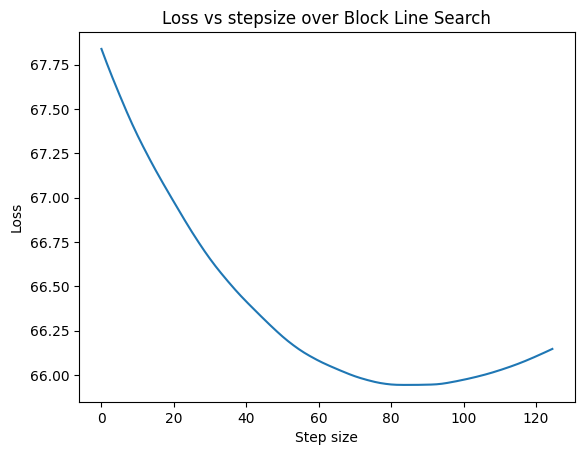

In [39]:
# plot for writeup
plt.plot(ls_hist['step_size'][:250], ls_hist['loss'][:250])
plt.xlabel('Step size')
plt.ylabel('Loss')
plt.title('Loss vs stepsize over Block Line Search')

In [40]:
def coord_step_linesearch(X_cur, i_k, g_ik, alpha:float):
    #hist_ls = []
    prev_loss = 1e10
    last_i = 0
    for i in range(100):
        step = - g_ik
        last_i = i
        X_cur[:,i_k] += alpha * step.flatten()
        l = fast_loss(A,b_onehot, X_cur)#
        # hist_ls.append({
        #     'iter': i,
        #     'loss': l
        # })
        if l > prev_loss:
            # by convexity, if the loss increases along our line search, stop searching.
            X_cur[:,i_k] -= alpha * step.flatten() # this is wastful: undoing work, but probably better than maintining the last X in memory
            break
        prev_loss = l
# ls_df = pd.DataFrame(hist_ls)
# ls_df
    return {'step_size': alpha * last_i, 'ls_steps':last_i}

In [41]:
hist_BCGD_GS_ls_df = BCGD(gs_coord_select, coord_step=coord_step_linesearch, max_iter=100, step_size=5)
hist_BCGD_GS_ls_df

iter       loss  accuracy  i_k   L2_g_ik  cpu_time  wall_time  step_size  \
0      0  65.942957     0.043   12  0.236762  0.000000   0.057510         85   
1      1  64.067944     0.060   40  0.236578  0.000000   0.106515         75   
2      2  61.991594     0.082   42  0.235149  0.015625   0.162025         90   
3      3  59.724534     0.108    8  0.232982  0.031250   0.218030         95   
4      4  57.723193     0.130   48  0.225257  0.062500   0.276081        100   
..   ...        ...       ...  ...       ...       ...        ...        ...   
76    76   0.155257     0.983    5  0.045737  2.140625   3.889123        115   
77    77   0.127416     0.986   13  0.050731  2.156250   3.921636         45   
78    78   0.114314     0.988   33  0.044333  2.171875   3.941642         20   
79    79   0.104043     0.989   47  0.039926  2.187500   3.964642         25   
80    80   0.099712     0.991   43  0.037627  2.203125   3.988640         30   

    ls_steps  
0         17  
1         15  
2         18  
3         19  
4         20  
..       ...  
76        23  
77         9  
78         4  
79         5  
80         6  

[81 rows x 9 columns]

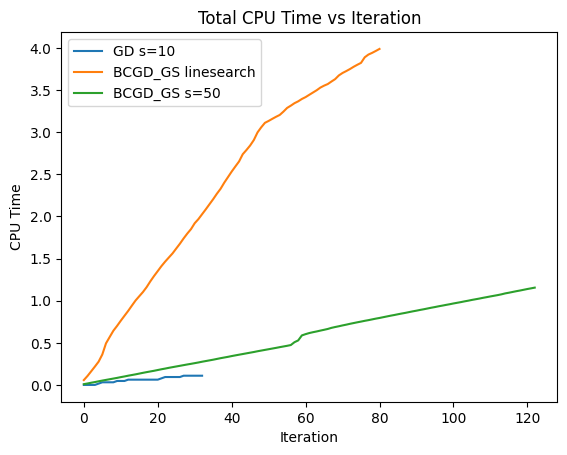

In [42]:
plt.plot(hist_gd_df['iter'], hist_gd_df['cpu_time'], label='GD s=10')
plt.plot(hist_BCGD_GS_ls_df['iter'],hist_BCGD_GS_ls_df['wall_time'], label='BCGD_GS linesearch')
plt.plot(hist_BCGD_GS_df['iter'],hist_BCGD_GS_df['wall_time'], label='BCGD_GS s=50')
plt.title('Total CPU Time vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('CPU Time')
plt.legend()

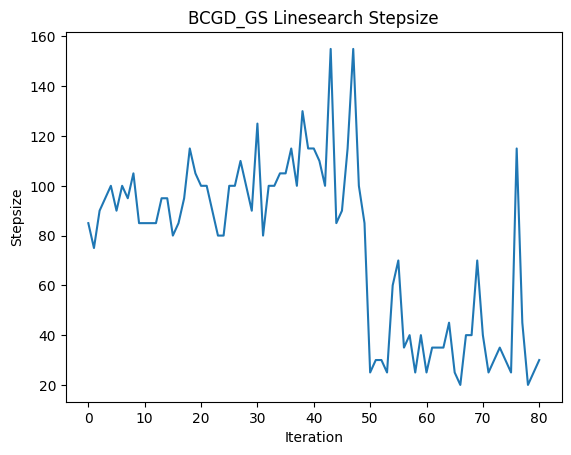

In [43]:
plt.plot(hist_BCGD_GS_ls_df['iter'], hist_BCGD_GS_ls_df['step_size'])
plt.xlabel('Iteration')
plt.ylabel('Stepsize')
plt.title('BCGD_GS Linesearch Stepsize')
plt.show()

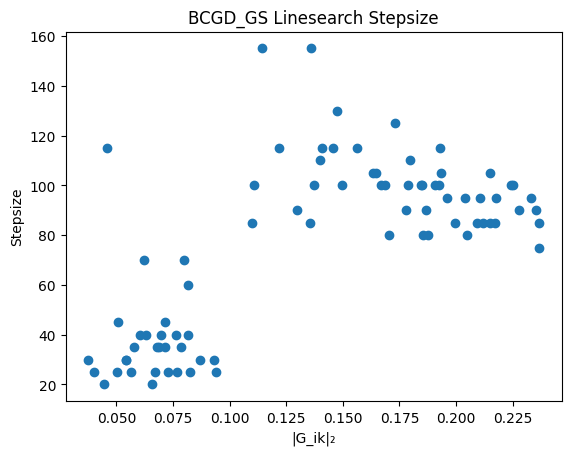

In [44]:
plt.scatter(hist_BCGD_GS_ls_df['L2_g_ik'], hist_BCGD_GS_ls_df['step_size'])
plt.xlabel('|G_ik|₂')
plt.ylabel('Stepsize')
plt.title('BCGD_GS Linesearch Stepsize')
plt.show()

# CORE BCGD METHODS

In [45]:
hist_BCGD_rand_df = BCGD(rand_coord_select, max_iter=500, step_size=50)
hist_BCGD_rand_df

iter       loss  accuracy  i_k   L2_g_ik  cpu_time  wall_time  step_size
0       0  66.171636     0.030    8  0.233130  0.000000   0.010000         50
1       1  65.267757     0.034   21  0.172185  0.000000   0.019002         50
2       2  64.064213     0.046   14  0.222324  0.000000   0.028005         50
3       3  62.496957     0.059   24  0.215386  0.015625   0.036005         50
4       4  61.541644     0.067   33  0.211749  0.015625   0.045520         50
..    ...        ...       ...  ...       ...       ...        ...        ...
236   236   0.094497     0.990   35  0.031613  1.453125   2.256489         50
237   237   0.094463     0.990   13  0.001168  1.453125   2.264489         50
238   238   0.091251     0.990   44  0.031133  1.453125   2.274488         50
239   239   0.091245     0.990   44  0.000350  1.453125   2.282490         50
240   240   0.090419     0.991   32  0.017320  1.453125   2.291491         50

[241 rows x 8 columns]

In [46]:
def plot_hist(X_val, Y_val, dfs, legend_lables, title = None):
    # Checking optimality conditions
    # want to plot only the histories before cond. met.

    fig = plt.figure()
    for i, hist_df in enumerate(dfs):
        plt.plot(hist_df[X_val], hist_df[Y_val], label=legend_lables[i])
    # plt.plot(hist_gd_df[gd_sele][X_val], hist_gd_df[gd_sele][Y_val], label='GD')
    # plt.plot(hist_BCGD_GS_df[gs_sele][X_val], hist_BCGD_GS_df[gs_sele][Y_val], label='GS')
    # plt.plot(hist_BCGD_rand_df[rand_sele][X_val], hist_BCGD_rand_df[rand_sele][Y_val], label = 'Random')
    plt.legend()
    plt.xlabel(X_val)
    plt.ylabel(Y_val)
    if title is not None:
        plt.title(title)
    plt.show()

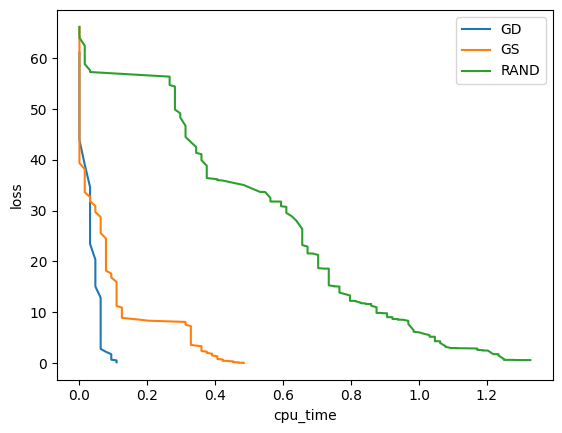

In [47]:
gd_sele = (hist_gd_df['grad_mag'] < 0.01).cumsum() == 0
gs_sele = (hist_BCGD_GS_df['L2_g_ik'] < 0.01).cumsum() == 0
rand_sele = (hist_BCGD_rand_df['L2_g_ik'] < 0.01).cumsum() < 30 # patience for random because prev. selected coords have low grad and can stop prematurely.
plot_hist('cpu_time', 'loss', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

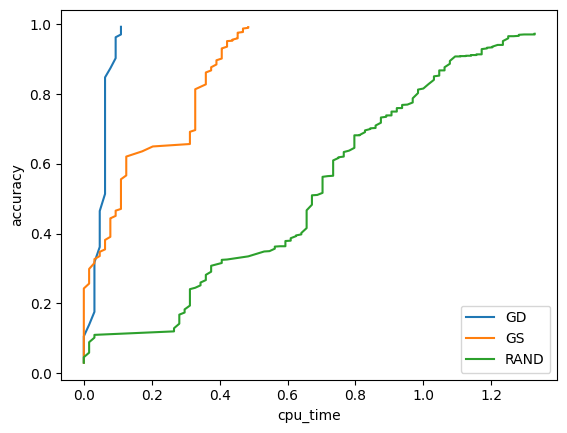

In [48]:
plot_hist('cpu_time', 'accuracy', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

# MNIST DATASET

In [49]:
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
digits_feats_df = optical_recognition_of_handwritten_digits.data.features / 16
digits_target_df = optical_recognition_of_handwritten_digits.data.targets 
 
digits_mask = digits_target_df['class'].isin([0,1,2,3,4])
digits_feats_df = digits_feats_df[digits_mask]
digits_target_df = digits_target_df[digits_mask]

In [50]:
b_names = digits_target_df['class'].to_numpy().reshape(-1,1) # rows are examples
b_cat_names = digits_target_df['class'].unique()
b_cat_names

OH_encoder = OneHotEncoder(sparse_output=False)
b_onehot = OH_encoder.fit_transform(b_names)
b_i = np.argmax(b_onehot, axis=1) # number corresponding to the class
A = digits_feats_df.to_numpy(dtype=float)
num_examples, example_dim = A.shape
num_classes = len(b_cat_names)
X0 = np.random.normal(0,1,size=(example_dim,num_classes))

In [52]:
step_size_digits = 1.5

In [53]:
digits_gd_df = gd(A,b_onehot, max_iter=1000, step_size=step_size_digits)

In [54]:
digits_bcgd_gs_df = BCGD(gs_coord_select, step_size=step_size_digits, max_iter=1000)

In [55]:
digits_bcgd_rand_df = BCGD(rand_coord_select, step_size=step_size_digits, max_iter=1000)

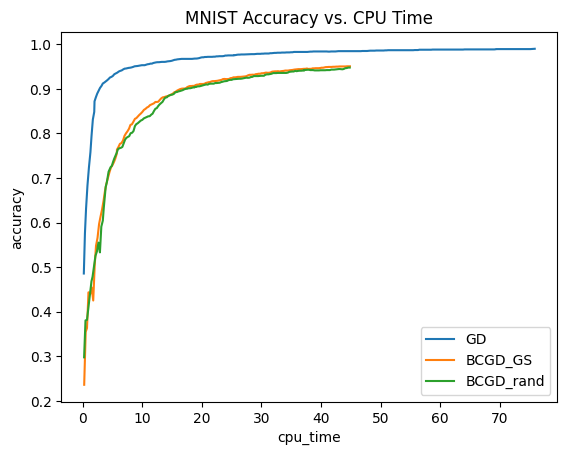

In [56]:
plot_hist('cpu_time', 'accuracy', [digits_gd_df, digits_bcgd_gs_df[digits_bcgd_gs_df['cpu_time'] < 45], digits_bcgd_rand_df[digits_bcgd_rand_df['cpu_time'] < 45]], ['GD', 'BCGD_GS', 'BCGD_rand'], title = "MNIST Accuracy vs. CPU Time")


# Emperical estimation of Lipschitz Constant

In [57]:
#grad(A, b_onehot, np.random.randn(0,1))
#L = []
#L_block = []
#L_block_norm = []
vars = [1]#, 0.5, 0.25, 0.1]
L_hist = []
for cur_var in vars:
    for i in range(100):
        X_rand = np.random.normal(0,0.5,size=(example_dim,num_classes))
        Y_rand = np.random.normal(0,0.5,size=(example_dim,num_classes))
        X_grad = grad(A, b_onehot, X_rand)
        Y_grad = grad(A, b_onehot, Y_rand)
        L_full = np.linalg.norm(X_grad - Y_grad,2)/np.linalg.norm(X_rand - Y_rand,2)
        #L.append(L_full)
        block_idx = np.random.randint(num_classes)
        X_grad_rand = grad_block(A, b_onehot, X_rand, block_idx)
        Y_grad_rand = grad_block(A, b_onehot, Y_rand, block_idx)
        X_grad_rand = grad_block(A, b_onehot, X_rand, block_idx)
        Y_grad_rand = grad_block(A, b_onehot, Y_rand, block_idx)
        L_block = np.linalg.norm(X_grad_rand - Y_grad_rand,2)/np.linalg.norm(X_rand - Y_rand,2)
        L_hist.append({'i':i, 'var':cur_var, 'L_full':L_full, 'block_idx':block_idx, 'L_block':L_block})
L_hist = pd.DataFrame(L_hist)

In [58]:
1 / L_hist['L_block'].mean()

8.684019519093688